In [1]:
import keras
import pandas as pd

from PIL import Image,ImageOps
import CharacterSegmentation as cs
from matplotlib.pyplot import figure
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model


In [2]:
INPUT_IMAGE =  'D:\\Ahmed\\AI\\OCR-master\\input\\input_7.jpeg'
SEGMENTED_OUTPUT_DIR = 'D:\\Ahmed\\AI\\OCR-master\\segmented\\'
EMNIST_PATH = './data/emnist/'
MODEL_PATH = 'D:\\Ahmed\\AI\\OCR-master\\model\\modelOCR4.h5'
mapping_processed ='D:\\Ahmed\\AI\\OCR-master\\data\\emnist\\processed-mapping_filtered_renumbered.csv'


## Character Segmentation

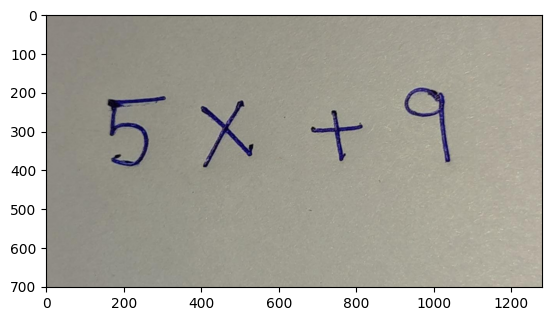

In [3]:
img = Image.open(INPUT_IMAGE)
plt.imshow(img)


In [4]:
cs.image_segmentation(INPUT_IMAGE)

Source image shape: (702, 1280)
Resized image shape: (723, 1320)
Binary image shape: (723, 1320)
Count array: [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   

In [5]:
segmented_images = []
files = [f for r, d, f in os.walk(SEGMENTED_OUTPUT_DIR)][0]
for f in files:
    segmented_images.append(Image.open(SEGMENTED_OUTPUT_DIR + f))

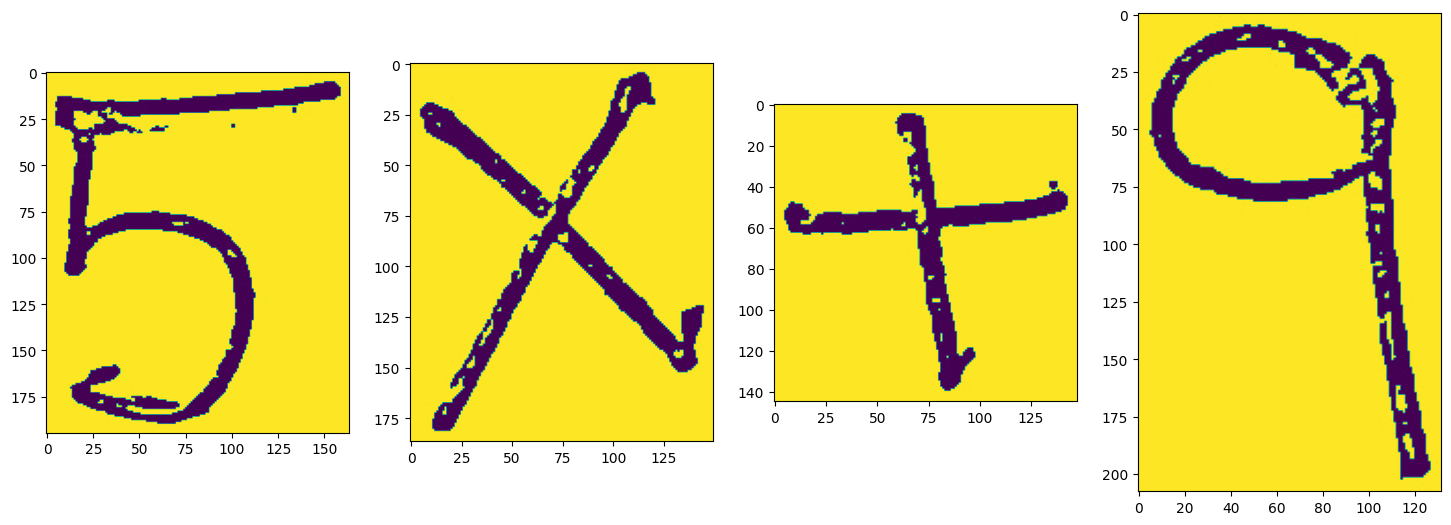

In [6]:
figure(figsize=(18,18))

size = len(segmented_images)
for i in range(size):
    img = segmented_images[i]
    plt.subplot(2, size, i + 1)
    plt.imshow(img)

## Making images bolder to avoid artifacts on resizing

In [7]:
import cv2

files = [f for r, d, f in os.walk(SEGMENTED_OUTPUT_DIR)][0]
for f in files:
    filename = SEGMENTED_OUTPUT_DIR + f
    img = cv2.imread(filename, 0)

    kernel = np.ones((2,2), np.uint8)
    dilation = cv2.erode(img, kernel, iterations = 1)
    cv2.imwrite(filename, dilation)

## Converting Segmented Characters to EMNIST format

In [8]:
def img2emnist(filepath, char_code):
    img = Image.open(filepath).resize((28, 28))
    inv_img = ImageOps.invert(img)
    
    flatten = np.array(inv_img).flatten()
    flatten = flatten / 255
    flatten = np.where(flatten > 0.5, 1, 0)
    
    csv_img = ','.join([str(num) for num in flatten])
    csv_str = '{},{}'.format(char_code, csv_img)
    return csv_str

In [9]:
temp_filename = 'test.csv'
if os.path.exists(temp_filename):
    os.remove(temp_filename)

f_test = open(temp_filename, 'a+')
column_names = ','.join(["label"] + ["pixel" + str(i) for i in range(784)])
print(column_names, file=f_test)

files = [f for r, d, f in os.walk(SEGMENTED_OUTPUT_DIR)][0]
for f in files:
    csv = img2emnist(SEGMENTED_OUTPUT_DIR + f, -1)
    print(csv, file=f_test)
    
f_test.close()

In [10]:
test_df = pd.read_csv(temp_filename)
test_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Character Recognition

In [11]:
data = pd.read_csv(temp_filename)
X_data = data.drop(labels = ["label"], axis = 1)
X_data = X_data.values.reshape(-1,28,28,1)

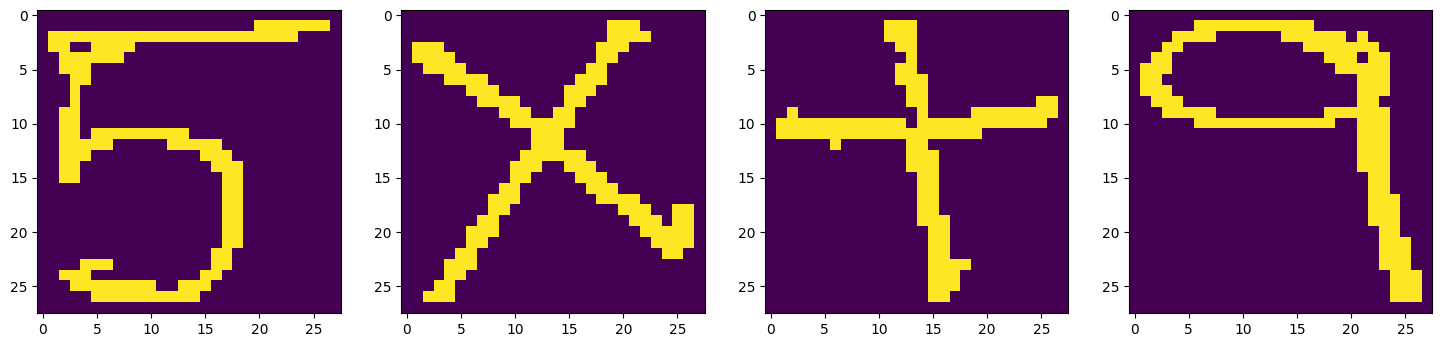

In [12]:
figure(figsize=(18,18))

size = X_data.shape[0]
for i in range(size):
    v = X_data[i][:,:,0].astype('uint8')
    img = Image.fromarray(255* v)
    
    plt.subplot(2, size, i + 1)
    plt.imshow(img)

In [13]:
df = pd.read_csv(mapping_processed)
code2char = {}
for index, row in df.iterrows():
    code2char[row['id']] = row['char']

In [14]:
model =load_model(MODEL_PATH)

In [15]:
# predict results
results = model.predict(X_data)

# select the index with the maximum probability
results = np.argmax(results, axis = 1)
parsed_str = ""
for r in results:
    parsed_str += code2char[r]

parsed_str

1/1 [==============================] - 0s 184ms/step


'5X+9'